After gathering the data we started with setting the dependencies and the functions that will help us in the project.
We defined a function that will give us a cross tabulation of the columns we pick and a function that will remove the outliers with the IQR method. 

In [365]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
from pyparsing import col
from scipy.stats import chi2_contingency
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree


def cross_tab(df,first_column,second_column):
    data = pd.crosstab(df[first_column],df[second_column],normalize='index')
    return data

def remove_outliers(df,column):
    Q1 = np.percentile(df[column],25)
    Q3 = np.percentile(df[column],75)
    IQR = Q3 - Q1
    wanted_col = df[column]
    wanted_col[(df[column] < Q1 - (1.5 * IQR)) | (df[column] < Q3 + (1.5 * IQR))] = np.nan
    return df

In [366]:
df = pd.read_csv('./DataFrame.csv')
for column in ["min_order","delivery_fee","amount_of_rankers","delivery_time_MAX"]:
    try:
        df = remove_outliers(df,column)
    except:
        print(column)
df.dropna(inplace=True)
df["delivery_time_MAX"] = df["delivery_time_MAX"].astype('int')
df.drop_duplicates(keep='first',inplace=True)
df.head()

C:\Users\almog\AppData\Local\Temp\ipykernel_4576\2930559082.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wanted_col[(df[column] < Q1 - (1.5 * IQR)) | (df[column] < Q3 + (1.5 * IQR))] = np.nan


,Unnamed: 0,names,countries,min_order,delivery_fee,amount_of_rankers,delivery_time_MAX,ranking
0,0,The Darling Pizzeria,Australia,13.167,4.9500,3977.0,40,3.89
1,1,Metro Pita Kebab,Australia,0.000,2.3034,840.0,40,4.27
2,2,Metro Thai,Australia,0.000,3.2934,6.0,35,5.22
3,3,BP - Randwick,Australia,0.000,0.6534,28.0,35,4.06
4,4,Naanstop On Norton,Australia,0.000,3.2934,5.0,35,5.27


We decided to give discrete values to continuous values since we planned on using the decision tree and random forest model. The continuous values were divided into bins according to the data we got.

After that, we started to clean the data and removed the duplicates and the nan values from the dataframe.

In order to keep the dataframe clean and numerical we also decided to map the countries to numbers according the dictionary we have down below.

In [367]:
replace_map = {'Australia':1,'England':2,'Ireland':3,'New Zeland':4}
bins = [-1,4,8,12,16,20,24,28]
bins_large_numbers = [-1,500,1000,1500,2000,2500,3000,5000]
bins_times = [20,30,40,50,60,70,80,90]
labels = [1,2,3,4,5,6,7]
df.replace(replace_map,inplace=True)
df['fee_without_food'] = df["min_order"] + df["delivery_fee"]
df["min_order_binned"] = pd.cut(df["min_order"],bins,labels=labels)
df["delivery_fee_binned"] = pd.cut(df["delivery_fee"],bins,labels=labels)
df["amount_of_rankers_binned"] = pd.cut(df["amount_of_rankers"],bins_large_numbers,labels=labels)
df["delivery_time_MAX_binned"] = pd.cut(df["delivery_time_MAX"],bins_times,labels=labels)
df["fee_without_food_binned"] = pd.cut(df["fee_without_food"],bins,labels=labels)
df['is_succesful'] = df['ranking'] > 4

df.dropna(inplace=True)
df.drop_duplicates(keep='first',inplace=True)


We also added the "is_successful" column to see which of the restaurants is successful and which is not according to the parameters we defined in the research question. In addition, we created the column "fee without food" which is the price customers will have to pay regardless of their dish.

After cleaning the data we wanted to see how our dataframe looks like. for that we used the head function to display the first 5 rows of the DF.

In [368]:
df.head()

,Unnamed: 0,names,countries,min_order,delivery_fee,amount_of_rankers,delivery_time_MAX,ranking,fee_without_food,min_order_binned,delivery_fee_binned,amount_of_rankers_binned,delivery_time_MAX_binned,fee_without_food_binned,is_succesful
0,0,The Darling Pizzeria,1,13.167,4.9500,3977.0,40,3.89,18.1170,4,2,7,2,5,False
1,1,Metro Pita Kebab,1,0.000,2.3034,840.0,40,4.27,2.3034,1,1,2,2,1,True
2,2,Metro Thai,1,0.000,3.2934,6.0,35,5.22,3.2934,1,1,1,2,1,True
3,3,BP - Randwick,1,0.000,0.6534,28.0,35,4.06,0.6534,1,1,1,2,1,True
4,4,Naanstop On Norton,1,0.000,3.2934,5.0,35,5.27,3.2934,1,1,1,2,1,True


Looks good! Seems like the columns look exactly as we expected.

After that we tried to find any correlation between some of the columns. we used Pearson method and created a correlation table that will display us the correlation between each column to the others.

In [369]:
df.corr(method ='pearson')

,Unnamed: 0,countries,min_order,delivery_fee,amount_of_rankers,delivery_time_MAX,ranking,fee_without_food,is_succesful
Unnamed: 0,1.000000,0.830910,0.275745,-0.115682,0.093864,0.544879,-0.015543,0.240955,-0.018938
countries,0.830910,1.000000,0.371535,-0.088532,0.096101,0.706034,-0.013447,0.344142,-0.021483
min_order,0.275745,0.371535,1.000000,-0.128775,0.149626,0.458794,0.019807,0.957956,0.022041
delivery_fee,-0.115682,-0.088532,-0.128775,1.000000,-0.105565,-0.031562,-0.012289,0.161167,-0.019995
amount_of_rankers,0.093864,0.096101,0.149626,-0.105565,1.000000,0.111598,0.023922,0.118367,0.011974
delivery_time_MAX,0.544879,0.706034,0.458794,-0.031562,0.111598,1.000000,-0.017694,0.447467,-0.017176
ranking,-0.015543,-0.013447,0.019807,-0.012289,0.023922,-0.017694,1.000000,0.016157,0.774438
fee_without_food,0.240955,0.344142,0.957956,0.161167,0.118367,0.447467,0.016157,1.000000,0.016150
is_succesful,-0.018938,-0.021483,0.022041,-0.019995,0.011974,-0.017176,0.774438,0.016150,1.000000


Trying to find any connection between the score of the restaurant and the minimum order, delivery fee, the amount of people who ranked the restaurant and what we call "fee without food" which is the money you have to pay without your actual dish. Not very impressive according to the table. most of the values are near 0 except the rating which doesn't count for obvious reasons.

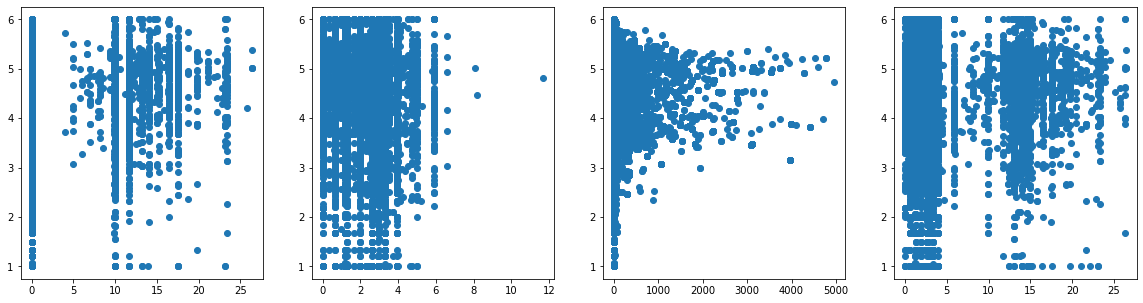

In [370]:

columns_for_scatter = ['min_order','delivery_fee','amount_of_rankers',"fee_without_food"]
fig,axes = plt.subplots(1,4,figsize = (20,5))
for i in range (4):
    axes[i].scatter(df[columns_for_scatter[i]],df['ranking'])    
plt.show()

Since these graphs doesn't provide us with any unambiguous conclusions, we tried the cross-tabulation score between the binned columns to the is successful column to see if we have a connection. 

In [371]:
for column in ["min_order_binned","delivery_fee_binned","amount_of_rankers_binned","delivery_time_MAX_binned"]:
    print(cross_tab(df,column,'is_succesful'))
    print('---------------------')



is_succesful         False      True
min_order_binned                    
1                 0.262743  0.737257
2                 0.170213  0.829787
3                 0.283881  0.716119
4                 0.190601  0.809399
5                 0.173127  0.826873
6                 0.200000  0.800000
7                 0.000000  1.000000
---------------------
is_succesful            False      True
delivery_fee_binned                    
1                    0.259329  0.740671
2                    0.345845  0.654155
3                    0.000000  1.000000
---------------------
is_succesful                 False      True
amount_of_rankers_binned                    
1                         0.261131  0.738869
2                         0.254511  0.745489
3                         0.229268  0.770732
4                         0.290323  0.709677
5                         0.106870  0.893130
6                         0.191176  0.808824
7                         0.449664  0.550336
------------------

We found some connection between some of the columns. the most relevant ones were the amount of rankers and the min order value.
We decided to check the binned columns in a bar plot to see if we can spot the connection in a more pleasant way than numbers.

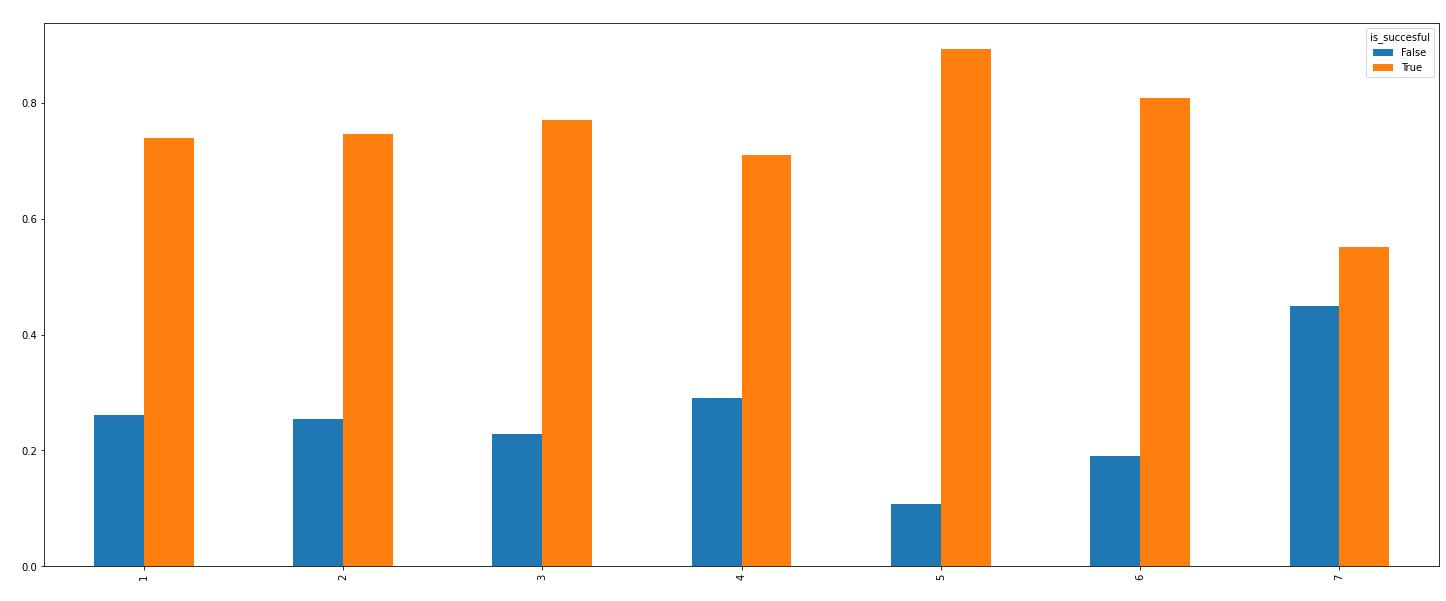

In [372]:
ct2 = cross_tab(df,"amount_of_rankers_binned",'is_succesful')
ct2.plot(kind = 'bar', figsize = (25,10))
plt.title('Successful vs unsuccessful resturants',color = 'white')
plt.xlabel('amount of rankers divided to bins',color = 'white')
plt.ylabel('Relative frequency',color = 'white')
plt.show()

As expected, we have a slight connection between the two. next, the min order.

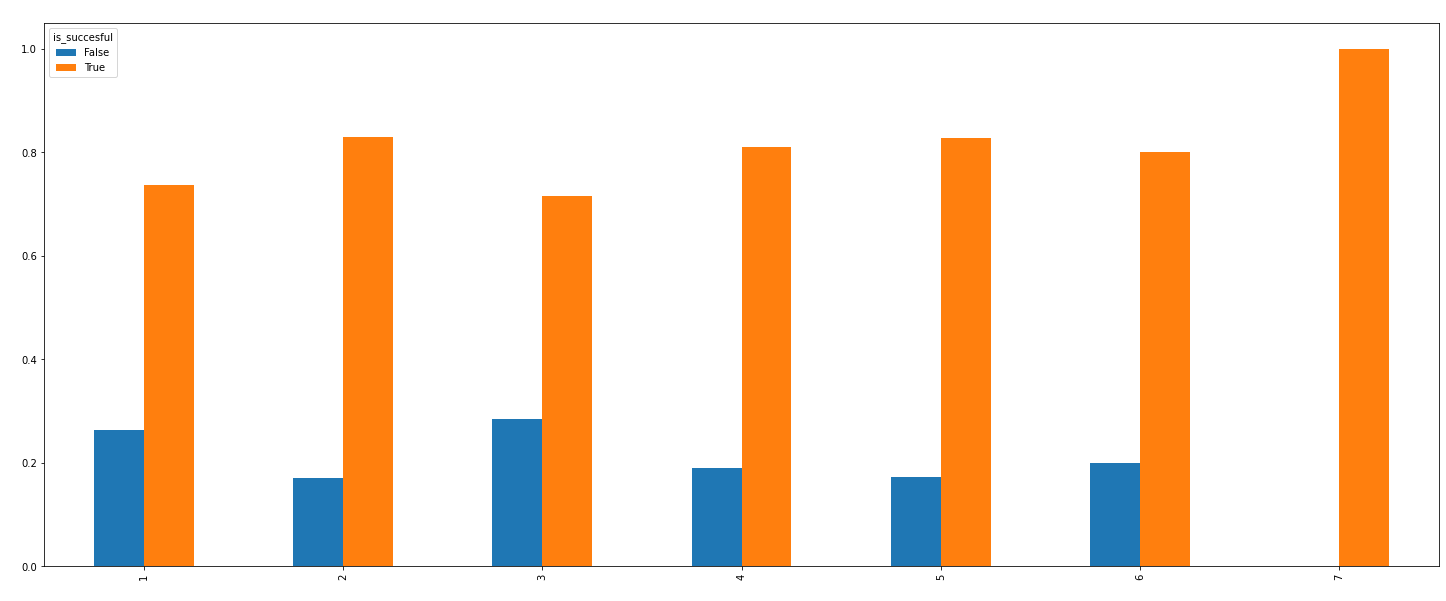

In [373]:
ct2 = cross_tab(df,"min_order_binned",'is_succesful')
ct2.plot(kind = 'bar', figsize = (25,10))
plt.title('Successful vs unsuccessful resturants',color = 'white')
plt.xlabel('Min order value devided to bins',color = 'white')
plt.ylabel('Relative frequency',color = 'white')
plt.show()

When it came to the minimum order. we found a stronger connection and a surprising one!
The frequency of successful restaurants was higher the bigger the value of the min order required for a delivery.

In order to validate we have a connection between those columns, we tried to run the chi2 score test on the unnormalized cross tabulation table.


In [374]:
chi2_contingency(pd.crosstab(df["min_order_binned"],df['is_succesful']))

(34.86799034887784,
 4.570852504292694e-06,
 6,
 array([[5.51828664e+03, 1.56507134e+04],
        [1.22518528e+01, 3.47481472e+01],
        [3.25065116e+02, 9.21934884e+02],
        [9.98395665e+01, 2.83160434e+02],
        [1.00882277e+02, 2.86117723e+02],
        [2.73711605e+01, 7.76288395e+01],
        [1.30338860e+00, 3.69661140e+00]]))

We found that since the P value of the chi2 test was less than 0.05, there is a connection between the variables!
Next we tried the amount of rankers in the same test.

In [375]:
chi2_contingency(pd.crosstab(df["amount_of_rankers_binned"],df['is_succesful']))

(48.716035512018266,
 8.498118250524326e-09,
 6,
 array([[ 5556.3455854 , 15758.6544146 ],
        [  274.49363835,   778.50636165],
        [  106.87786488,   303.12213512],
        [   56.56706507,   160.43293493],
        [   34.14878122,    96.85121878],
        [   17.72608491,    50.27391509],
        [   38.84098017,   110.15901983]]))

And we also found a connection here! Seems like the P value here is less than 0.05 which means there is a connection between the columns

After cleaning the data, displaying what we have in graphs and assuming and establishing connection between columns we moved on to the next step and started to build the ML model that will try and predict the success rate as we defined it in the beginning.

Since we have a few parameters that we want to take in consideration and the final decision should be a truth or false kind of answer, we decided to use the Decision tree classifier and Random forest classifier. We chose that since the issue we have decided to investigate resembled a lot to the Titanic survivors issue that was displayed in the course.

In [376]:

decisionTree = tree.DecisionTreeClassifier()
res_predictors = df[["countries","amount_of_rankers_binned","delivery_time_MAX_binned","fee_without_food_binned","min_order_binned"]].values
res_labels = df["is_succesful"].values
XTrain, XTest, yTrain, yTest = train_test_split(res_predictors, res_labels, random_state=1, test_size=0.5)
decisionTree = decisionTree.fit(XTrain, yTrain)
y_pred_train = decisionTree.predict(XTrain)
print('Accuracy on training data = ',metrics.accuracy_score(y_true = yTrain, y_pred = y_pred_train))
y_pred = decisionTree.predict(XTest)
print('Accuracy on test data = ', 
      metrics.accuracy_score(y_true = yTest, y_pred = y_pred))



Accuracy on training data =  0.7444092194327822
Accuracy on test data =  0.7369773817683345


Next we tried the Random forest classifier and got around the same results in this model as well.

In [377]:
from sklearn.ensemble import RandomForestClassifier

forest =  RandomForestClassifier(bootstrap=True, n_estimators=300, random_state=0)

trained_forest = forest.fit(XTrain, yTrain) 

y_pred_train = trained_forest.predict(XTrain)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = yTrain, y_pred = y_pred_train))

y_pred = trained_forest.predict(XTest)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = yTest, y_pred = y_pred))

Accuracy on training data=  0.7444092194327822
Accuracy on test data=  0.7379198080877313


Final Report:

After collecting the data, preparing it for the tests, building a machine learning model and applying the model on our data we got to a decent prediction percentage of 74%.

After discussing on the percentage and figuring out how we can improve the model we decided to leave it at that. We reached to a conclusion that data in real life is different than the data we got in the course. while in the course we got a premade data sets that will probably were designed to give us good prediction percentage, here this is information that was gathered from a dynamic website that keeps on updating and changing on a regular base. This means that the percentage will probably not be similar to what we got in class.

We also discussed on the matter that a success of a restaurant is determined by a lot of factors that cannot be measured or data we simply couldn't get due to it not being available or run time complexity. Service quality, dish size and quality of products are some of the factors that are either really hard to measure or just couldn't be measured. On the other hand, average dish price is an example of a factor that may be very important but would make our algorithm time complexity increase significally. 

Even though 74% is not that impressive we were satisfied by the outcome. We faced numerous challenges and we overcame them as a team from facing the denial of access to the just eat site to the EDA and visualization and then the machine learning model. 

We learned a lot during the project and even were a little surprised from the results. This project definitely helped us understand the steps of a data scientist when facing an issue in this subject.